In [14]:
from algorithms_pca.matrix import Matrix
from algorithms_pca.linear_solver import gauss_solver
from algorithms_pca.statistics import center_data, covariance_matrix
from algorithms_pca.eigen import find_eigenvalues, find_eigenvectors
from algorithms_pca.pca import pca
from algorithms_pca.visualization import plot_pca_projection
from algorithms_pca.utils import auto_select_k, apply_pca_to_dataset, add_noise_and_compare

import matplotlib.pyplot as plt

In [15]:
A = Matrix([[4, 7], [2, 6]])
B = Matrix([[3, 8], [5, 1]])
print("A + B =", A + B)
print("A - B =", A - B)
print("A * B (elem) =", A * B)
print("A.matmul(B) =", A.matmul(B))
print("A.T =", A.T)
print("det(A) =", A.determinant())
print("inv(A) =", A.inverse())
print("rank(A) =", A.rank())
print("trace(A) =", A.trace())
P, L, U = A.lu()
print("P, L, U =", P, L, U)
x = A.solve(Matrix([[1], [0]]))
print("Solution x to Ax=b =", x)
x = gauss_solver(A, Matrix([[1], [0]]))
print("Solution x to Ax=b =", x)

A = Matrix([[1, 2, 3], [4, 5, 6], [7, 8, 10]])
x = A.solve(Matrix([[6], [15], [25]]))
print("Solution x to Ax=b =", x)

x = gauss_solver(A, Matrix([[6], [15], [25]]))
print("Solution x to Ax=b =", x)

A = Matrix([
    [1, 2, -1],
    [-2, -4, 2],
    [3, 6, -3]
])
b = Matrix([
    [1],
    [-2],
    [3]
])

solutions = gauss_solver(A, b)
print(solutions)

A + B = Matrix([[7, 15], [7, 7]])
A - B = Matrix([[1, -1], [-3, 5]])
A * B (elem) = Matrix([[12, 56], [10, 6]])
A.matmul(B) = Matrix([[47.0, 39.0], [36.0, 22.0]])
A.T = Matrix([[4, 2], [7, 6]])
det(A) = 10.0
inv(A) = Matrix([[0.6000000000000001, -0.7000000000000001], [-0.2, 0.4]])
rank(A) = 2
trace(A) = 10
P, L, U = Matrix([[1.0, 0.0], [0.0, 1.0]]) Matrix([[1.0, 0.0], [0.5, 1.0]]) Matrix([[4, 7], [0.0, 2.5]])
Solution x to Ax=b = Matrix([[0.6000000000000001], [-0.2]])
Solution x to Ax=b = [Matrix([[0.6000000000000001], [-0.2]])]
Solution x to Ax=b = Matrix([[-6.142857142857159], [47.42857142857147], [-31.142857142857167]])
Solution x to Ax=b = [Matrix([[1.0000000000000013], [0.9999999999999969], [1.0000000000000016]])]
[Matrix([[1.0], [0.0], [0.0]]), Matrix([[-2.0], [1.0], [0.0]]), Matrix([[1.0], [0.0], [1.0]])]


In [16]:
X = Matrix([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])

X_centered, _ = center_data(X)
print("Центрированная матрица:")
print(X_centered)

cov = covariance_matrix(X_centered)
print("Матрица ковариаций:")
print(cov)

Центрированная матрица:
Matrix([[-3.0, -3.0, -3.0], [0.0, 0.0, 0.0], [3.0, 3.0, 3.0]])
Матрица ковариаций:
Matrix([[9.0, 9.0, 9.0], [9.0, 9.0, 9.0], [9.0, 9.0, 9.0]])


In [17]:
C = Matrix([[1, 2],
            [2, 4]])
eigenvalues = find_eigenvalues(C)
print("Eigenvalues:", eigenvalues)

eigenvectors = find_eigenvectors(C, eigenvalues)
print("Eigenvectors:")
for v in eigenvectors:
    print(v)

Eigenvalues: [-0.0, 5.0]
Eigenvectors:
Matrix([[-0.894427], [0.447214]])
Matrix([[0.447214], [0.894427]])


Projected data (n×k): Matrix([[-2.828428, 0.0], [0.0, 0.0], [2.828428, 0.0]])
Explained variance ratio: 1.0000
Projected data (n×k):
[[-2.82842712]
 [ 0.        ]
 [ 2.82842712]]
Explained variance ratio: 1.0000


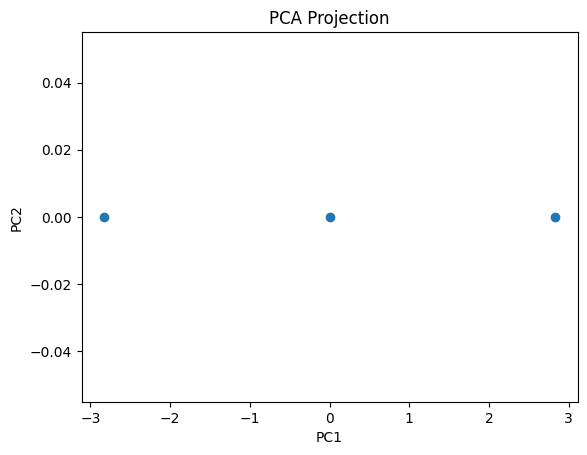

In [18]:
sample_data = Matrix([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
X_p, explained = pca(sample_data, k=2)
print(f"Projected data (n×k): {X_p}")
print(f"Explained variance ratio: {explained:.4f}")
plot_pca_projection(X_p)

import numpy as np

sample_data = np.array([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

mean = np.mean(sample_data, axis=0)
X_centered = sample_data - mean

cov_matrix = np.cov(X_centered, rowvar=False)

eigen_values, eigen_vectors = np.linalg.eigh(cov_matrix)

sorted_idx = np.argsort(eigen_values)[::-1]
eigen_vectors_sorted = eigen_vectors[:, sorted_idx]
eigen_values_sorted = eigen_values[sorted_idx]

k = 1
components = eigen_vectors_sorted[:, :k]

X_p = X_centered @ components

explained = eigen_values_sorted[:k].sum() / eigen_values_sorted.sum()

print("Projected data (n×k):")
print(X_p)
print(f"Explained variance ratio: {explained:.4f}")

In [19]:
X = Matrix([
    [2.5, 2.4, 1.2, 3.1, 0.5],
    [0.5, 0.7, 1.5, 2.9, 0.3],
    [2.2, 2.9, 0.9, 3.2, 0.6],
    [1.9, 2.2, 1.0, 3.0, 0.4],
    [3.1, 3.0, 1.3, 3.5, 0.7],
    [2.3, 2.7, 1.1, 3.3, 0.5],
])

eig = find_eigenvalues(covariance_matrix(center_data(X)[0]))
auto_select_k(eig, 0.95)

2

In [20]:
X_example = Matrix([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
result = add_noise_and_compare(X_example, noise_level=0.2)
print("Selected k:", result['k'])
print("Explained ratio (orig):", result['ratio_orig'])
print("Explained ratio (noisy):", result['ratio_noisy'])

X_proj_iris, ratio_iris = apply_pca_to_dataset('iris', 1)
print(f"Iris dataset projected shape: ({X_proj_iris.rows}, {X_proj_iris.cols})")
print("Explained ratio (iris, k=2):", ratio_iris)


Selected k: 1
Explained ratio (orig): 1.0
Explained ratio (noisy): 0.9958409568641384
Iris dataset projected shape: (150, 1)
Explained ratio (iris, k=2): 0.9246197749811391


In [21]:
data = Matrix([
    [-1, -6],
    [2, 6]])
eigenvalues = find_eigenvalues(data)
eigenvectors = find_eigenvectors(data, eigenvalues)



print("\nСобственные значения:", [f"{λ:.3f}" for λ in eigenvalues])
print("\nСобственные векторы:")
for i, vec in enumerate(eigenvectors):
    print(vec)


Собственные значения: ['2.000', '3.000']

Собственные векторы:
Matrix([[-0.894427], [0.447214]])
Matrix([[-0.83205], [0.5547]])


Выбранное k = 2
PCA_QR explained variance ratio = 0.9777
sklearn explained variance ratio = 0.9581


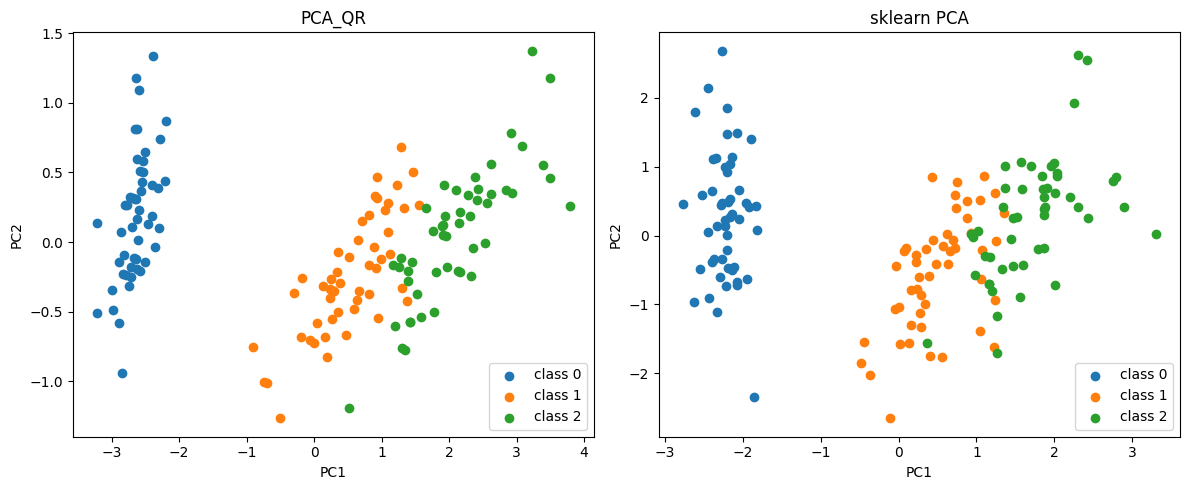

Accuracy PCA_QR + LogisticRegression = 0.9778
Accuracy sklearn PCA + LogisticRegression = 0.8667


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA as SklearnPCA

from algorithms_pca.matrix import Matrix
from algorithms_pca.pca import pca_qr
from algorithms_pca.statistics import center_data
from algorithms_pca.utils import auto_select_k


def matrix_to_np(X: Matrix) -> np.ndarray:
    return np.array(X._data)

def visualize(X_my, X_sk, y):
    plt.figure(figsize=(12,5))
    for i, (Xp, title) in enumerate([(X_my, "PCA_QR"), (X_sk, "sklearn PCA")], 1):
        plt.subplot(1,2,i)
        for cls in np.unique(y):
            plt.scatter(Xp[y==cls,0], Xp[y==cls,1], label=f"class {cls}")
        plt.title(title)
        plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()
    plt.tight_layout()
    plt.show()

# 1. загрузка
data = load_iris()
X_np = data.data
y = data.target
X = Matrix(X_np.tolist())

# 2. стандартизация для sklearn
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_np)

# 3. автоподбор k по QR-PCA
Xc, _ = center_data(X)
Cov = Xc.T @ Xc / X.rows
eigvals = Cov.qr_eigen()[0]
k = auto_select_k(eigvals, threshold=0.95)
print("Выбранное k =", k)

# 4. PCA_QR
X_proj_qr, ratio_qr, raw_vals, W, means = pca_qr(X, k)
Xp_qr_np = matrix_to_np(X_proj_qr)
print(f"PCA_QR explained variance ratio = {ratio_qr:.4f}")

# 5. sklearn PCA
sk_pca = SklearnPCA(n_components=k)
Xp_sk = sk_pca.fit_transform(X_scaled)
print(f"sklearn explained variance ratio = {sk_pca.explained_variance_ratio_.sum():.4f}")

# 6. сравнение проекций
visualize(Xp_qr_np, Xp_sk, y)

# 7. классификация на проекциях
X_train_qr, X_test_qr, y_train, y_test = train_test_split(
    Xp_qr_np, y, test_size=0.3, random_state=0)
X_train_sk, X_test_sk, _, _ = train_test_split(
    Xp_sk, y, test_size=0.3, random_state=0)

clf_qr = LogisticRegression(max_iter=1000).fit(X_train_qr, y_train)
clf_sk = LogisticRegression(max_iter=1000).fit(X_train_sk, y_train)

acc_qr = accuracy_score(y_test, clf_qr.predict(X_test_qr))
acc_sk = accuracy_score(y_test, clf_sk.predict(X_test_sk))

print(f"Accuracy PCA_QR + LogisticRegression = {acc_qr:.4f}")
print(f"Accuracy sklearn PCA + LogisticRegression = {acc_sk:.4f}")